In [ ]:
!pip install --upgrade pyspark

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Install and set up PySpark in Colab
!pip install -q findspark
!pip install -q pyspark

# Import necessary libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Create a Spark session
spark = SparkSession.builder.appName("Colab").getOrCreate()
spark = SparkSession.builder.appName("KNN_Classifier").getOrCreate()



In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Change the Directory to Machine Learning folder
%cd /content/drive/My Drive/Big Data

/content/drive/My Drive/Big Data


In [ ]:
# Read CSV into a Spark DataFrame
train_data = spark.read.option("header", "true").csv('/content/drive/My Drive/Big Data/train.csv', inferSchema=True)

In [ ]:
# Display the first few rows of the DataFrame
train_data.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
|          6|       0|     3|    Moran, Mr. James|  male|NULL|    0|    0|      

In [ ]:
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from pyspark.ml.clustering import KMeans

In [ ]:
# Drop columns that are not being used
columns_to_drop = ['PassengerID', 'Name', 'Ticket', 'Cabin', 'Embarked']
train_data = train_data.drop(*columns_to_drop)

# Convert categorical variables
from pyspark.ml.feature import StringIndexer

# Use a different variable name for the StringIndexer object
indexer = StringIndexer(inputCols=["Sex"], outputCols=["Sex_indexed"])
indexed_data = indexer.fit(train_data).transform(train_data)

# Drop the original "Sex" column
indexed_data = indexed_data.drop("Sex")
#Drop rows with NaN values
cleaned_data = indexed_data.na.drop()
# Verify changes
cleaned_data.show()


+--------+------+----+-----+-----+-------+-----------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Sex_indexed|
+--------+------+----+-----+-----+-------+-----------+
|       0|     3|22.0|    1|    0|   7.25|        0.0|
|       1|     1|38.0|    1|    0|71.2833|        1.0|
|       1|     3|26.0|    0|    0|  7.925|        1.0|
|       1|     1|35.0|    1|    0|   53.1|        1.0|
|       0|     3|35.0|    0|    0|   8.05|        0.0|
|       0|     1|54.0|    0|    0|51.8625|        0.0|
|       0|     3| 2.0|    3|    1| 21.075|        0.0|
|       1|     3|27.0|    0|    2|11.1333|        1.0|
|       1|     2|14.0|    1|    0|30.0708|        1.0|
|       1|     3| 4.0|    1|    1|   16.7|        1.0|
|       1|     1|58.0|    0|    0|  26.55|        1.0|
|       0|     3|20.0|    0|    0|   8.05|        0.0|
|       0|     3|39.0|    1|    5| 31.275|        0.0|
|       0|     3|14.0|    0|    0| 7.8542|        1.0|
|       1|     2|55.0|    0|    0|   16.0|        1.0|
|       0|

In [ ]:
# Check the number of rows
num_rows = indexed_data.count()

# Check the number of columns
num_columns = len(indexed_data.columns)

# Display the shape
print(f"Number of rows: {num_rows}, Number of columns: {num_columns}")

Number of rows: 891, Number of columns: 7


In [ ]:
from pyspark.sql.functions import col, stddev, mean

# Assuming 'cleaned_data' is your cleaned DataFrame
numeric_columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_indexed']

# Define the threshold for standard deviations
std_dev_threshold = 3.0

# Calculate mean and standard deviation for each numeric column
statistics = cleaned_data.select(*[stddev(column).alias(column + '_stddev') for column in numeric_columns] +
                                 [mean(column).alias(column + '_mean') for column in numeric_columns]).collect()[0]

# Create a DataFrame with z-scores
outliers_removed_data = cleaned_data.select(
    '*',
    *[((col(column) - statistics[column + '_mean']) / statistics[column + '_stddev']).alias(column + '_z_score')
      for column in numeric_columns]
)

# Filter out rows with z-scores beyond the threshold
filter_conditions = [(col(column + '_z_score') <= std_dev_threshold) & (col(column + '_z_score') >= -std_dev_threshold)
                      for column in numeric_columns]

outliers_removed_data = outliers_removed_data.filter(
    filter_conditions[0] & filter_conditions[1] & filter_conditions[2] & filter_conditions[3] & filter_conditions[4] & filter_conditions[5]
)

# Drop the z-score columns
outliers_removed_data = outliers_removed_data.drop(*[column + '_z_score' for column in numeric_columns])

# Display the result
outliers_removed_data.show()



+--------+------+----+-----+-----+-------+-----------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Sex_indexed|
+--------+------+----+-----+-----+-------+-----------+
|       0|     3|22.0|    1|    0|   7.25|        0.0|
|       1|     1|38.0|    1|    0|71.2833|        1.0|
|       1|     3|26.0|    0|    0|  7.925|        1.0|
|       1|     1|35.0|    1|    0|   53.1|        1.0|
|       0|     3|35.0|    0|    0|   8.05|        0.0|
|       0|     1|54.0|    0|    0|51.8625|        0.0|
|       0|     3| 2.0|    3|    1| 21.075|        0.0|
|       1|     3|27.0|    0|    2|11.1333|        1.0|
|       1|     2|14.0|    1|    0|30.0708|        1.0|
|       1|     3| 4.0|    1|    1|   16.7|        1.0|
|       1|     1|58.0|    0|    0|  26.55|        1.0|
|       0|     3|20.0|    0|    0|   8.05|        0.0|
|       0|     3|14.0|    0|    0| 7.8542|        1.0|
|       1|     2|55.0|    0|    0|   16.0|        1.0|
|       0|     3|31.0|    1|    0|   18.0|        1.0|
|       0|

In [ ]:
#Visualize outliers
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

numeric_columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_indexed']

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = outliers_removed_data.toPandas()

# Create box plots for each numeric column
for column in numeric_columns:
    sns.boxplot(x=pandas_df[column])
    plt.title(f'Box Plot for {column}')
    plt.show()


In [ ]:
from pyspark.sql import functions as F

# Calculate mean and standard deviation for each numeric column
statistics = cleaned_data.select(
    *[F.mean(F.col(feature)).alias(feature + "_mean") for feature in numeric_columns] +
    [F.stddev(F.col(feature)).alias(feature + "_std") for feature in numeric_columns]
).collect()[0]

# Calculate scaled values for each numeric column
scaled_data = cleaned_data.select(
    "*",
    *[((F.col(feature) - statistics[feature + '_mean']) / statistics[feature + '_std']).alias(feature + '_scaled')
      for feature in numeric_columns]
)

# Drop the original and mean/stddev columns
scaled_data = scaled_data.drop(*[feature + '_mean' for feature in numeric_columns] + [feature + '_std' for feature in numeric_columns])

# Display the result
scaled_data.show()



+--------+------+----+-----+-----+-------+-----------+-------------------+--------------------+-------------------+-------------------+--------------------+-------------------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Sex_indexed|      Pclass_scaled|          Age_scaled|       SibSp_scaled|       Parch_scaled|         Fare_scaled| Sex_indexed_scaled|
+--------+------+----+-----+-----+-------+-----------+-------------------+--------------------+-------------------+-------------------+--------------------+-------------------+
|       0|     3|22.0|    1|    0|   7.25|        0.0|  0.910594031798256| -0.5300050983330729| 0.5242026579654963|-0.5055407535895291| -0.5186143080290967|-0.7585196075927614|
|       1|     1|38.0|    1|    0|71.2833|        1.0|-1.4753294129868995|  0.5714304118216116| 0.5242026579654963|-0.5055407535895291|  0.6914120587537427| 1.3165110430632985|
|       1|     3|26.0|    0|    0|  7.925|        1.0|  0.910594031798256| -0.2546462207944017|-0.5513165885499184|

In [ ]:
from pyspark.ml.feature import VectorAssembler

# The'scaled_data' DataFrame with scaled features
assembler = VectorAssembler(
    inputCols=["Pclass_scaled", "Age_scaled", "SibSp_scaled", "Parch_scaled", "Fare_scaled", "Sex_indexed_scaled"],
    outputCol="input_features"
)

# Transform the data to include the features column
assembled_data = assembler.transform(scaled_data)

# Split the data into training and testing sets (80% training, 20% testing)
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=42)

# Display the number of rows in each set
print("Training set count:", train_data.count())
print("Testing set count:", test_data.count())


Training set count: 600
Testing set count: 114


In [ ]:
#Spark MLib does not have a built in KNN implementation
#Steps to follow for KNN implementation
#1. Convert the Spark DataFrame to Pandas DataFrame
#2. Train a KNN model using scikit-learn
#3. Evaluate model

In [ ]:
!pip install scikit-learn


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = scaled_data.toPandas()

# Define features and target
X = pandas_df[['Pclass_scaled', 'Age_scaled', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled', 'Sex_indexed_scaled']]
y = pandas_df['Survived']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use scikit-learn's KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = knn_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")


Accuracy: 74.83%


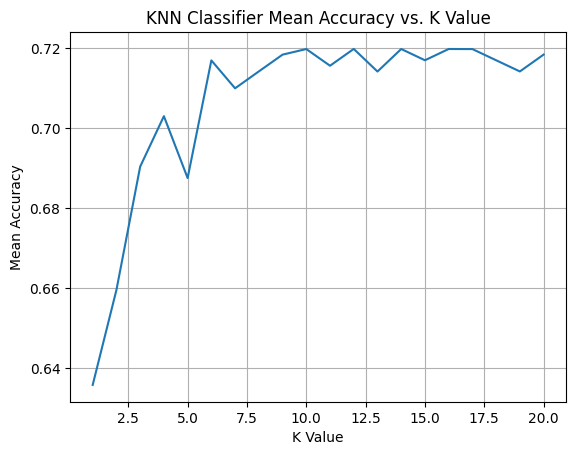

The best K value is: 12


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Assuming 'X' and 'y' are your features and target variable
X = scaled_data.select("Age_scaled", "SibSp_scaled", "Parch_scaled", "Fare_scaled").toPandas()
y = scaled_data.select("Survived").toPandas()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a list of K values to try
k_values = list(range(1, 21))

accuracy_scores = []

for k in k_values:
    # Create a KNN classifier with the current K value
    knn = KNeighborsClassifier(n_neighbors=k)

    # Perform 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores_kfold = cross_val_score(knn, X, y.values.ravel(), cv=kf, scoring='accuracy')

    # Record mean accuracy
    accuracy_mean = np.mean(accuracy_scores_kfold)
    accuracy_scores.append(accuracy_mean)

# Plot the accuracy scores for different K values
plt.plot(k_values, accuracy_scores)
plt.xlabel("K Value")
plt.ylabel("Mean Accuracy")
plt.title("KNN Classifier Mean Accuracy vs. K Value")
plt.grid(True)
plt.show()

# Find the best K value
best_k = k_values[np.argmax(accuracy_scores)]
print("The best K value is:", best_k)

# Create a KNN classifier with the best K value
best_knn = KNeighborsClassifier(n_neighbors=best_k)

# Train the model on the entire training dataset
best_knn.fit(X_train, y_train.values.ravel())

# Make predictions on the test data
y_pred = best_knn.predict(X_test)



In [ ]:
!pip install scikit-learn


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,  precision_score, recall_score, f1_score
import numpy as np

# Assuming 'X' and 'y' are your features and target variable
X = scaled_data.select("Age_scaled", "SibSp_scaled", "Parch_scaled", "Fare_scaled").toPandas()
y = scaled_data.select("Survived").toPandas()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a KNN classifier with the best K value
best_knn_model = KNeighborsClassifier(n_neighbors=12)

# Perform 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_knn_model, X_train, y_train.values.ravel(), cv=cv, scoring='accuracy')

# Report mean and standard deviation of cross-validation scores
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores) * 100:.2f}%")
print(f"Standard Deviation of Cross-Validation Accuracy: {np.std(cv_scores) * 100:.2f}%")

# Train the model on the entire training dataset
best_knn_model.fit(X_train, y_train.values.ravel())

# Make predictions on the test data
y_pred = best_knn_model.predict(X_test)

# Create a confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:")
print(confusion)
print(f"\nPrecision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100: .2f}%")
print(f"F1 Score: {f1*100: .2f}%")

Mean Cross-Validation Accuracy: 73.38%
Standard Deviation of Cross-Validation Accuracy: 2.83%
Confusion Matrix:
[[73 14]
 [35 21]]

Precision: 60.00%
Recall:  37.50%
F1 Score:  46.15%



## Model Evaluation

### Mean Cross-Validation Accuracy:
The K-Nearest Neighbors (KNN) classifier was evaluated using 5-fold cross-validation. The mean accuracy across the folds was found to be approximately 73.38%, which means, on average, the model correctly predicted the survival status of passengers in the dataset.

### Standard Deviation of Cross-Validation Accuracy:
The standard deviation of the cross-validation accuracy was calculated to be approximately 2.83%. This measure provides insight into the changeability of the model's performance across different folds. A lower standard deviation suggests more consistent performance.

### Confusion Matrix:
The confusion matrix provides a detailed breakdown of the model's predictions. In this case:
- True Positives (TP): 73
- False Positives (FP): 14
- False Negatives (FN): 35
- True Negatives (TN): 21

### Precision, Recall, and F1 Score:
- Precision: 60.00%
  Precision represents the proportion of true positive predictions among all positive predictions. In this context, it indicates the accuracy of the model in predicting actual survivals among the predicted survivals.

- Recall: 37.50%
  Recall, also known as sensitivity or true positive rate, represents the proportion of actual positives that were correctly predicted by the model. In this context, it indicates the model's ability to capture all actual survivals.

- F1 Score: 46.15%
  The F1 score is the consonant mean of precision and recall, providing a balance between the two metrics. It is particularly useful when there is an uneven class distribution. It indicates that the model performed moderately well in correctly identifying survivors while minimizing false positives.

Overall, the KNN classifier demonstrates reasonable performance, with room for improvement in capturing true positives and minimizing false negatives.












